# Experimental feature: Calculating lexical diversity of limericks to rank and select
Rami Ariss, March 30th 2022

NLTK (Natural Language Toolkit, https://www.nltk.org/) is a useful python package to do various text-based statistical and metric calculations.

For example, we can use NLTK to define sets of text to calculate the lexical diversity over a limerick, and rank a set of generated limericks based on the lexical diversity.

NLTK can enable metric calculations such as:
- lexical diversity: % words repeatedly used in given text
- collocations: words used together often
- word counts

Resources:
- Parts of Speech Tags: https://www.ibm.com/docs/en/watson-explorer/10.0.0?topic=analytics-part-speech-tag-sets
- NLTK examples: https://www.nltk.org/book/ch01.html
- NLTK Pre-Process notebook example: https://colab.research.google.com/github/gal-a/blog/blob/master/docs/notebooks/nlp/nltk_preprocess.ipynb#scrollTo=0JzUMH4jdXm7

In [68]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Notebook Preparation

In [69]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Not connected to a GPU


In [70]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger') 
nltk.download('treebank')

import pandas as pd
import matplotlib.pyplot as plt
import io
import unicodedata
import numpy as np
import re
import string
import json
import glob
import os

from scipy import stats
import seaborn as sns

%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package treebank to /root/nltk_data...
[nltk_data]   Package treebank is already up-to-date!


# Lexical Diversity

In [71]:
def calculate_lexical_diversity(text):
  """Given a tokenized text, calculate its lexical diversity.

  :param text: list, tokenized text
  :return: float, lexical diversity
  """
  return len(set(text)) / len(text)

def calculate_lexical_diversities(poems):
  """Calculate lexical diversity for a set of poems

  :param poems: list, poems as strings
  :return: list, lexical diversities (decimals)
  """
  lexical_diversity = []
  for poem in poems:
    # flatten each poem into a line
    flattened_poem = ' '.join(poem)

    # tokenize
    tokens = nltk.word_tokenize(flattened_poem)

    lexical_diversity.append(calculate_lexical_diversity(tokens))
  return np.array(lexical_diversity)

In [72]:
def format_poem(poem):
  """Reformat a poem given as a list of lines for cleaner printing

  :param poem: list, each line is a string in list
  :return: str
  """
  return '\n'.join(poem)

In [73]:
def lexical_diversity_stats(poems, lexical_diversity):
  i_most_diverse = np.argmax(lexical_diversity)
  i_least_diverse = np.argmin(lexical_diversity)

  print(f'Number of poems: {len(poems)}\n Lexical Diversity:\n  Mean: {np.round(np.mean(lexical_diversity) * 100)}%\n  Max: {np.round(np.max(lexical_diversity)* 100)}%\n  Min: {np.round(np.min(lexical_diversity) * 100)}%')
  print(stats.describe(lexical_diversity))

  print(f'\nLexical Diversity: {np.round(lexical_diversity[i_most_diverse]*100)}%\n', format_poem(poems[i_most_diverse]))

  print(f'\nLexical Diversity: {np.round(lexical_diversity[i_least_diverse]*100)}%\n', format_poem(poems[i_least_diverse]))

# Data

Limerick files can be found under `/data/raw` in the github repository. Manually upload to `sample_data` in colab (had issues with mounting).

In [96]:
DATA_DIR = 'drive/MyDrive/11-785_IDL/automatic_poetry_generation/data'
!ls $DATA_DIR

classification	preprocessing  raw


## Load OEDILF Limericks

In [106]:
def json_poems(fname):
  """Cleans up poems in the parsed jsons format into a list of strings and calculates lexical diversity"""
  f = open(fname)
  poems_json = json.load(f)
  
  poems = []
  for k, p in poems_json['limericks'].items():
    poems.append(p['lines'])

  return poems_json, poems

In [107]:
oedilf_poems_json, oedilf_poems = json_poems(os.path.join(DATA_DIR, 'preprocessing/limericks.json'))

In [108]:
oedilf_lexical_diversity = calculate_lexical_diversities(oedilf_poems)

In [109]:
lexical_diversity_stats(oedilf_poems, oedilf_lexical_diversity)

Number of poems: 72432
 Lexical Diversity:
  Mean: 84.0%
  Max: 100.0%
  Min: 3.0%
DescribeResult(nobs=72432, minmax=(0.03278688524590164, 1.0), mean=0.8353434158972181, variance=0.004465899011799556, skewness=-0.5835692832571296, kurtosis=2.712162211084711)

Lexical Diversity: 100.0%
 we are atheist authors, and know
theists think us irreverent... whoa!
all the wonders unfurled
in this mind-blowing world
make our pantheist awe overflow.

Lexical Diversity: 3.0%
 ???? ??????'? ? ??? ?? ? ???, ??.
????? '?' ?? ??? ??, '?' ?? ?????,
??? ? ???'? ???? ??? '?',
??? ??'? ??? ????? ?? ?? ?
??'? ? ?????? ??????? ?? ?? ??????.


In [118]:
oedilf_poems_lexical_diversity = {}
for i, (k, v) in enumerate(oedilf_poems_json['limericks'].items()):
  oedilf_poems_lexical_diversity[k] = {
      'poem': v['lines'],
      'lexical_diversity': oedilf_lexical_diversity[i]
  }

In [125]:
output_fpath = os.path.join(DATA_DIR, 'raw/oedilf_lexical_diversity.json')
with open(output_fpath, 'w') as fp:
    json.dump(oedilf_poems_lexical_diversity, fp)

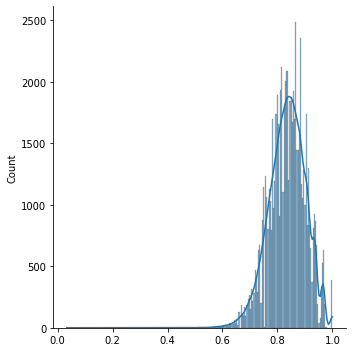

In [ ]:
sns.displot(oedilf_lexical_diversity, kde=True)

# Load Two-stage LM Generated Limericks

In [76]:
def generated_json_poems(fname):
  """Cleans up poems in the parsed jsons format into a list of strings and calculates lexical diversity"""
  f = open(fname)
  poems_json = json.load(f)
  
  poems = {}
  for k, p in poems_json.items():
    poems[k] = p.split('\n')  #convert back to list of line strings

  return poems_json, poems

In [77]:
free_form_fpath = os.path.join(DATA_DIR, '04_21_free_form_spell_checked_12832.json')
free_form_poems_json, free_form_poems = generated_json_poems(free_form_fpath)

In [78]:
free_form_lexical_diversity = calculate_lexical_diversities(free_form_poems.values())

In [79]:
lexical_diversity_stats(list(free_form_poems.values()), free_form_lexical_diversity)

Number of poems: 12832
 Lexical Diversity:
  Mean: 77.0%
  Max: 100.0%
  Min: 16.0%
DescribeResult(nobs=12832, minmax=(0.15841584158415842, 1.0), mean=0.7742928692331247, variance=0.006301550600854192, skewness=-0.6661800132922039, kurtosis=2.489193671136264)

Lexical Diversity: 100.0%
 I'm not using computers to make
but these gadgets? the world makes me quake
if they use this device
as that gadget, is nice
it's an error from every mistake

Lexical Diversity: 16.0%
 some of us are sure that it's true
many months have been long overdue
but, sadly of late
we're of late now, I'm late ? are you? we are late as well, too
<PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>


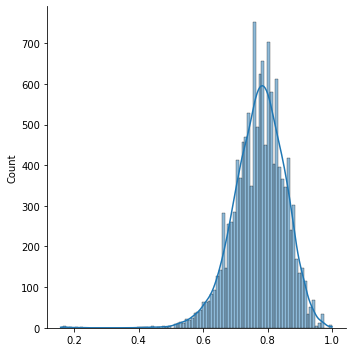

In [80]:
sns.displot(free_form_lexical_diversity, kde=True)

In [89]:
# Filter out bassed on lexical diversity threshold
threshold = 0.835 - 2*np.sqrt(0.004468)  # threshold based on mean-2*std of oedilf dataset

In [ ]:
# Print to see poems that will be removed
for i, k in enumerate(free_form_poems):
  if free_form_lexical_diversity[i] <= threshold:
    print(free_form_lexical_diversity[i], free_form_poems[k])

In [90]:
filtered_free_form_poems = {}
for i, k in enumerate(free_form_poems):
  if free_form_lexical_diversity[i] > threshold:
    filtered_free_form_poems[k] = {
        'poem': free_form_poems[k],
        'lexical_diversity': free_form_lexical_diversity[i]
        }

In [91]:
print(f'Total Poems: {len(free_form_poems)}')
print(f'Kept Poems: {len(filtered_free_form_poems)}')
print(f'Removed Poems: {len(free_form_poems)-len(filtered_free_form_poems)}')

Total Poems: 12832
Kept Poems: 10702
Removed Poems: 2130


In [92]:
output_fpath = os.path.join(DATA_DIR, '04_21_free_form_spell_checked_12832_ld_10702.json')
with open(output_fpath, 'w') as fp:
    json.dump(filtered_free_form_poems, fp)

# Generated Poems

In [ ]:
def generated_poems(fname):
  """Cleans up generated poems and into a list of strings and calculates lexical diversity"""
  # read file
  with open(fname) as f:
    lines = f.readlines()
  
  # parse into list of poems
  poems = [[]]
  i = 0  # limerick index
  for l in lines:
    l = l.strip()  # remove '\n'
    # if empty line (new limerick)
    if len(l) == 0:
      poems.append([])
      i += 1
    else:
      poems[i].append(l)
  poems = poems[:-1] # exclude last blank

  lexical_diversity = calculate_lexical_diversities(poems)

  return poems, lexical_diversity

In [ ]:
free_form_poems, free_form_ld = generated_poems('free_form.txt')

In [ ]:
lexical_diversity_stats(free_form_poems, free_form_ld)

Number of poems: 499
 Lexical Diversity:
  Mean: 81.0%
  Max: 100.0%
  Min: 39.0%
DescribeResult(nobs=499, minmax=(0.391304347826087, 1.0), mean=0.8053598750469538, variance=0.004659879277132748, skewness=-0.747760410605702, kurtosis=2.7550725600563863)

Lexical Diversity: 100.0%
 though einstein's theorem was sound
with its logic intact, it would soon
be considered in depth
how a math axiomal
of the whole world without end can't defeat

Lexical Diversity: 39.0%
 as a girl, were my dreams quite unfulfilled
were they bright? were they dull? were they slurred
were their faces dull? were they bright
were they dull? were they dull
were they faded? were they faded? were they blurbed


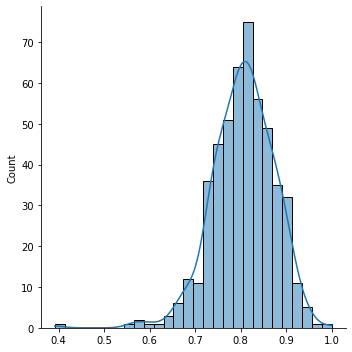

In [ ]:
sns.displot(free_form_ld, kde=True)

In [ ]:
once_poems, once_ld = generated_poems('once_upon_a_time.txt')

In [ ]:
lexical_diversity_stats(once_poems, once_ld)

Number of poems: 500
 Lexical Diversity:
  Mean: 82.0%
  Max: 100.0%
  Min: 51.0%
DescribeResult(nobs=500, minmax=(0.5142857142857142, 1.0), mean=0.8236863217927167, variance=0.0058257248161856096, skewness=-0.460930201985876, kurtosis=0.4275594552083648)

Lexical Diversity: 100.0%
 once upon a time
logometry's being sublime
we know geometry
and clear analogy
has made all your life in the slime

Lexical Diversity: 51.0%
 once upon a time
you thought that, to me, was a rhyme
you thought that was a rhyme
was a time, not a time
and it not was in many a crime


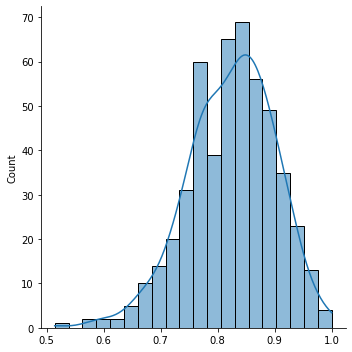

In [ ]:
sns.displot(once_ld, kde=True)

In [ ]:
sample_poems, sample_ld = generated_poems('sample.txt')

In [ ]:
lexical_diversity_stats(sample_poems, sample_ld)

Number of poems: 4980
 Lexical Diversity:
  Mean: 79.0%
  Max: 100.0%
  Min: 25.0%
DescribeResult(nobs=4980, minmax=(0.25, 1.0), mean=0.7924710505086469, variance=0.007888457087812342, skewness=-0.744639485175195, kurtosis=1.186489398897491)

Lexical Diversity: 100.0%
 to keep infantry marching in line
they defend us, we stand and define
the army of battalions
our strong british galleons
with self-uppance: there is a sign

Lexical Diversity: 25.0%
 tomorrow... tomorrow... tomorrow..
tomorrow... tomorrow... tomorrow... tomorrow....
tomorrow...... tomorrow.. tomorrow....
encumber...... tomorrow..
encumber..... tomorrow..


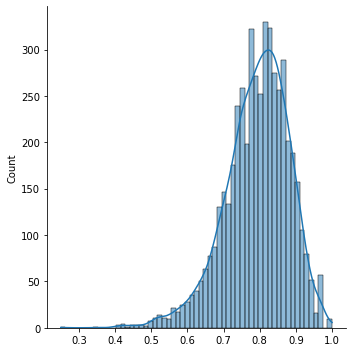

In [ ]:
sns.displot(sample_ld, kde=True)

## Raw Poems for Testing

In [ ]:
poems_raw = """
I'd rather watch the clouds in the sky
though don't climb to a field, and i'll try
make the sky always clear
because nobody's here
you'll say i'll not fly off the eye

I'd rather watch the clouds in the sky
but ignore it, take care if you'd die
if you fly on a fly
you'd be seen in the sky
or a comerfly, put your way high

I'd rather watch the clouds in the sky
and clouds, if i'd take on a try
of the cloud, and, say
that the clouds had held sway..
being such an observant was i

I'd rather watch the clouds in the sky
that were conically shaped like a pie
and they'd fall in the night
simply fall, not just right
and to fall, they could fall way up high

I'd rather watch the clouds in the sky
for his eyes with a scientist's eye
to observe and observe
to observe, observe, observe
are a change from my mind, smile and sigh

I'd rather watch the clouds in the sky
ae and stars that are bigger than i
far from sea to up high
from a view in the sky
help me up. so thanks to heaven, i'm high

I'd rather watch the clouds in the sky
i look over; my love, so i cry
if i give you my love
and you come up above
if i sit there? bye, dear, goodbye

I'd rather watch the clouds in the sky
like the clouds, though they fly way up high
cloudy arcs in the sky
all that arc as they fly
or the shadow that flies like the sky

I'd rather watch the clouds in the sky
at convenience store, purchase and buy
hop to shop for a day
do some think they're away
at the convenience store, purchase and buy

I'd rather watch the clouds in the sky
i tried hard just to climb up, and then try
to come up and to fly
i'm to get to the sky
it would sure come away with my sigh
"""

In [ ]:
def raw_output_to_poems(raw_output: str):
    """Parse a raw text representation of multiple poems into a list of poems

    :param raw_output: poem as a string (like txt files we sentto Rita)
    :return: list of poems, where each poem is a list of lines
    """
    poems = raw_output.split('\n\n')
    poems = [poem.strip() for poem in poems]
    poems = [poem.split('\n') for poem in poems]

    lexical_diversity = calculate_lexical_diversities(poems)
    return poems, lexical_diversity

In [ ]:
raw_poems, raw_ld = raw_output_to_poems(poems_raw)

In [ ]:
lexical_diversity_stats(raw_poems, raw_ld)

Number of poems: 10
 Lexical Diversity:
  Mean: 74.0%
  Max: 82.0%
  Min: 66.0%
DescribeResult(nobs=10, minmax=(0.6578947368421053, 0.825), mean=0.7411999075702542, variance=0.001954573151103121, skewness=0.00013474930109814943, kurtosis=0.32126968353586927)

Lexical Diversity: 82.0%
 I'd rather watch the clouds in the sky
though don't climb to a field, and i'll try
make the sky always clear
because nobody's here
you'll say i'll not fly off the eye

Lexical Diversity: 66.0%
 I'd rather watch the clouds in the sky
like the clouds, though they fly way up high
cloudy arcs in the sky
all that arc as they fly
or the shadow that flies like the sky


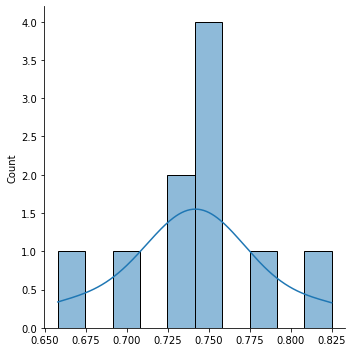

In [ ]:
sns.displot(raw_ld, kde=True)

# Parts of Speech Tagging

In [ ]:
def get_parts_of_speech(poem, pos):
  """Given a single poem and desired pos, return a dictionary of the words with that pos

  :param poem: list, list of strings for each poem line
  :param pos: list, lost of strings for each pos (can pass just the start abbreviation)
  :return: list, tuples of all tokenized words and tagged pos
  :return: dict, keys are pos, values are (word, pos)
  """
  tokens = nltk.word_tokenize(' '.join(poem))
  tagged = nltk.pos_tag(tokens)
  
  # Get specific POS tags
  pos = {k: [] for k in pos}

  for k in pos:
    for w, p in tagged:
      if p.startswith(k):
        pos[k].append((w, p))
  return tagged, pos

In [ ]:
tagged, pos = get_parts_of_speech(sample_poems[0], ['NN', 'V'])

In [ ]:
for k in pos:
  print(f'# of {k}: {len(pos[k])}')
pos

# of NN: 9
# of V: 7


{'NN': [('beware', 'NN'),
  ('cayenne', 'NN'),
  ('peppers', 'NNS'),
  ('onion', 'NN'),
  ('cabbage', 'NN'),
  ('sauce', 'NN'),
  ('loss', 'NN'),
  ('sauce', 'NN'),
  ('pot', 'NN')],
 'V': [('are', 'VBP'),
  ("'re", 'VBP'),
  ("'s", 'VBZ'),
  ("'s", 'VBZ'),
  ('blame', 'VB'),
  ("'s", 'VBZ'),
  ('say', 'VBP')]}